# HW2P2: Face Classification and Verification


This is the second homework in 11785: Introduction to Deep Learning consisting of two parts:
*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7001 identities.
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities.

For this HW, you only have to write code to implement your model architecture. Everything else has been provided for you, on the pretext that most of your time will be used up in developing the suitable model architecture for achieving satisfactory performance.

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# TODOs
As you go, please read the code and keep an eye out for TODOs.

**Structure of this notebook**:

1. **Libraries** - just run it
2. **Kaggle** - copy the code from HW1P2 and add a correct API key
3. **Configs** - specify your configs
4. **Dataset**
  - **Datasets and Dataloaders** - it's already implemented, just specify your preferred augmentations/transformations
  - **EDA and Viz** - just run it to check if your augmentations/transformations worked
5. **Model Architecture** - implement and define your preferred model architecture
6. **Loss, Optimizer, and Scheduler** - define your loss, optimizer, and a scheduler
7. **Training and Validation Functions** - includes functions for both classification and verification tasks
  - **Classification Task** - just run it
  - **Verification Task** - just run it
8. **Wandb** - add a correct API key
9. **Experiments** - make changes if needed; it will show you train/val/test accuracy for both classification and verification. **Important**: make sure you save your best model checkpoints because models in this HW take a long time to get trained
10. **Testing and Kaggle Submission** - just run it
11. **Model Finetuning** - this part might help you get a higher score on the verification part
  - **Model Implementations (CenterLoss, ArcFace, or SphereFace)** - please refer to the additional notebook and just copy the model from there
  - **Model Definition (finetuning)** - you may reuse the code from the main part
  - **Loss, Optimizer, and Scheduler Definition (finetuning)** - you may reuse the code from the main part
  - **Training Function (finetuning)** - you may reuse the code from the main part
  - **Wandb (finetuning)** - you may reuse the code from the main part
  - **Experiments (finetuning)** - you may reuse the code from the main part

Good luck!

# Libraries

In [ ]:
!nvidia-smi # Run this to see what GPU you have

Sun Feb 18 19:54:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#NOTE: RESTART THE RUN TIME AFTER RUNNING THE THE CELL BELOW

In [ ]:
# Install the necessary packages. Very important: Please restart your session in Colab/Local Machine
# You can restart your session in colab by going to Runtime and then clicking restart session
!pip install wandb --quiet
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 59.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu121
    Uninstalling torchvision-0.16.0+cu121:
      Successfully uninstalled torchvision-0.16.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.1.0+cu121
    Uninstalling torchaudio-2.1.0+cu121:
      Successfully uninstalled torchaudio-2.1.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.7.0 requires torch==2.1.0,

In [ ]:
# Import the important packages for this Homework. Feel free to add anything here you need.
import torch
from torchsummary import summary
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
# from google.colab import drive # Link to your drive if you are not using Colab with GCP
# drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"xueyingjiashirley","key":"65930698151c15846b9e3248655cffbf"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw2p2-face-recognition
!unzip -qo '11785-hw2p2-face-recognition.zip' -d '/content/data'

!kaggle competitions download -c 11785-hw2p2-face-verification
!unzip -qo '11785-hw2p2-face-verification.zip' -d '/content/data'

 99% 1.69G/1.71G [00:09<00:00, 220MB/s]
100% 1.71G/1.71G [00:09<00:00, 188MB/s]
 48% 8.00M/16.8M [00:00<00:00, 82.4MB/s]
100% 16.8M/16.8M [00:00<00:00, 130MB/s] 


# Configs

In [ ]:
config = {
    'batch_size': 64, # Increase this if your GPU can handle it
    'lr': 0.1,
    'epochs': 20, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'min_lr': 1e-6
    # Include other parameters as needed.
}

# Dataset

## Datasets and Dataloaders

In [ ]:
# --------------------------------------------------- #

# Data paths
# TODO: Path where you have downloaded the classificaation data
DATA_DIR    = '/content/data/11-785-s24-hw2p2-classification'
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #

# Transformations/augmentations of the Train dataset

"""
Refer https://pytorch.org/vision/stable/transforms.html
Implementing the right train transforms/augmentation methods is key to improving performance.
Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
But there are some transforms which are performed after ToTensor() : e.g - Normalization
#Normalization Tip - Do not blindly use normalization that is not suitable for this dataset
"""

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    torchvision.transforms.ToTensor()
    ]) # TODO: Specify transformations/augmentations performed on the train dataset

# --------------------------------------------------- #

# Transformations/augmentations of the Val dataset

"""
You should NOT have data augmentation on the validation set. Why?
"""

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ]) # TODO: Specify transformations performed on the val dataset

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           # num_workers = 4, # Uncomment this line if you want to increase your num workers
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = False,
                                           # num_workers = 2 # Uncomment this line if you want to increase your num workers
                                           )

In [ ]:
# --------------------------------------------------- #

# Test dataset class

"""
You can do this with ImageFolder as well, but it requires some tweaking
"""

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = config['batch_size'],
                                          shuffle     = False,
                                          drop_last  = False,
                                          # num_workers = 2 # Uncomment this line if you want to increase your num workers
                                          )

## EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  64
Train batches        :  2188
Val batches          :  547


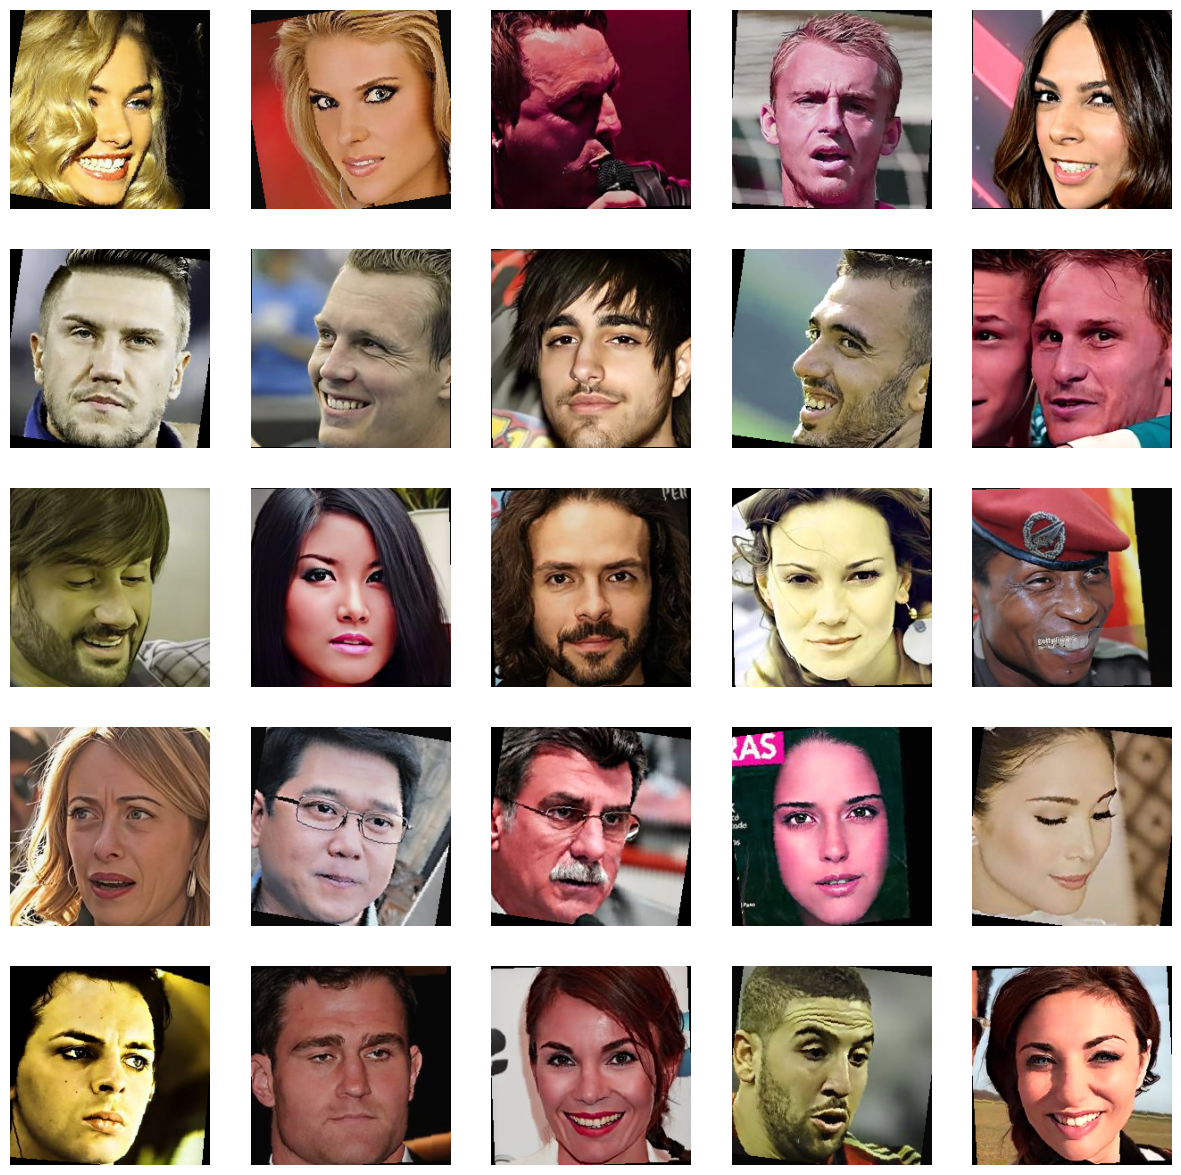

In [ ]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next four have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 224x224. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [ ]:
# # TODO: Fill out the model definition below
# import torch.nn as nn
# 
# class Network(torch.nn.Module):
# 
#     def __init__(self, num_classes=7001):
#         super().__init__()
# 
#         self.backbone = torch.nn.Sequential(
# 
#             # TODO
#             nn.Conv2d(3, 64, kernel_size=7, stride=4, padding=7//2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=3//2),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=3//2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=3//2),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=3//2),
#             nn.BatchNorm2d(1024),
#             nn.ReLU(inplace=True),
#             nn.AdaptiveAvgPool2d((1, 1))
# 
#             )
#         #TODO
#         self.cls_layer = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(1024, num_classes)
#         )
# 
#     def forward(self, x, return_feats=False):
# 
#         feats = self.backbone(x)
#         out = self.cls_layer(feats)
# 
#         if return_feats:
#             return feats
#         else:
#             return out
# 
# # Initialize your model
# model = Network().to(DEVICE)
# summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,472
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
            Conv2d-4          [-1, 128, 28, 28]          73,856
       BatchNorm2d-5          [-1, 128, 28, 28]             256
              ReLU-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 256, 14, 14]         295,168
       BatchNorm2d-8          [-1, 256, 14, 14]             512
              ReLU-9          [-1, 256, 14, 14]               0
           Conv2d-10            [-1, 512, 7, 7]       1,180,160
      BatchNorm2d-11            [-1, 512, 7, 7]           1,024
             ReLU-12            [-1, 512, 7, 7]               0
           Conv2d-13           [-1, 1024, 4, 4]       4,719,616
      BatchNorm2d-14           [-1, 102

In [ ]:
# SE-ResNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SEResNetBottleneck(nn.Module):

    # change from 4 to 2
    expansion = 2

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(out_channels * self.expansion, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class SEResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(SEResNet, self).__init__()

        # stem
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def seresnet50(**kwargs):
    # change 3, 4, 6, 3 to 4, 6, 2, 2
    model = SEResNet(SEResNetBottleneck, [4, 6, 2, 2], **kwargs)
    return model

# Create a SE-ResNet-50 model
model = seresnet50(num_classes=7001)

# Print the number of parameters in the model
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.')

# Loss, Optimizer, and Scheduler Definition

In [ ]:
# --------------------------------------------------- #

# Defining Loss function
# TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=7001, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = -1

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

criterion = LabelSmoothingLoss(classes=7001, smoothing=0.1)
# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=config['lr'],
                            momentum=0.9,
                            weight_decay=1e-4) # TODO: Feel free to pick a different optimizer

# --------------------------------------------------- #

# Defining Scheduler
# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=1, cooldown=0, min_lr=1e-6)

# TODO: change learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'], eta_min=config['min_lr']



# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

# Training and Validation Functions

## Classification Task

In [ ]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [ ]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

## Verification Task

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [ ]:
# This obtains the list of known identities from the known folder
known_regex = "/content/data/11-785-s24-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

print(f"Shape of unknown_dev_images: {unknown_dev_images.shape}")
print(f"Shape of unknown_test_images: {unknown_test_images.shape}")
print(f"Shape of known_images: {known_images.shape}")

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 12108.45it/s]


Shape of unknown_dev_images: torch.Size([360, 3, 224, 224])
Shape of unknown_test_images: torch.Size([720, 3, 224, 224])
Shape of known_images: torch.Size([960, 3, 224, 224])


In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?
    # for known_feature in known_feats:
    #   sim_value = similarity(unknown_feats, known_feature)
    #   print(sim_value)

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()

    predictions = predictions.flatten().astype(int).tolist()

    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    # threshold = # Choose a proper threshold
    # NO_CORRESPONDENCE_LABEL = 'n000000'
    # pred_id_strings = []
    # for idx, prediction in enumerate(predictions):
    #     if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
    #         pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
    #     else:
    #         pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv('/content/data/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [ ]:
wandb.login(key="2f0e719c10f41f0ced321484f29a97a076f8c72a") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Currently logged in as: xjia2 (supersuper). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "early-submission-Xueying", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

# Experiments

In [ ]:
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion) # TODO: What function would you want implement here

    print("\nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion) # TODO: What function would you want implement here
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    scheduler.step(val_acc)

    if val_acc >= best_class_acc:
        best_valid_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification.pth')
        wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification.pth')
      wandb.save('checkpoint_verification.pth')
      print("Saved verification model")

### Finish your wandb run
run.finish()


Epoch 1/20



Train Acc (Classification) 1.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 15.0173


Val Acc (Classification) 17.0818%	 Val Loss (Classification) 5.6884


Verification Accuracy = 15.0
Val Acc (Verification) 15.0000%	 
Saved best classification model
Saved verification model

Epoch 2/20



Train Acc (Classification) 2.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 31.5192


Val Acc (Classification) 33.7580%	 Val Loss (Classification) 4.7063


Verification Accuracy = 18.055555555555554
Val Acc (Verification) 18.0556%	 
Saved best classification model
Saved verification model

Epoch 3/20



Train Acc (Classification) 3.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 46.0516


Val Acc (Classification) 42.3932%	 Val Loss (Classification) 4.3180


Verification Accuracy = 19.444444444444446
Val Acc (Verification) 19.4444%	 
Saved best classification model
Saved verification model

Epoch 4/20



Train Acc (Classification) 4.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 55.9822


Val Acc (Classification) 21.8721%	 Val Loss (Classification) 5.5541


Verification Accuracy = 16.666666666666664
Val Acc (Verification) 16.6667%	 
Saved best classification model

Epoch 5/20



Train Acc (Classification) 5.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 62.4200


Val Acc (Classification) 46.2009%	 Val Loss (Classification) 4.1108


Verification Accuracy = 21.38888888888889
Val Acc (Verification) 21.3889%	 
Saved best classification model
Saved verification model

Epoch 6/20



Train Acc (Classification) 6.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 66.8697


Val Acc (Classification) 27.9136%	 Val Loss (Classification) 5.3679


Verification Accuracy = 15.0
Val Acc (Verification) 15.0000%	 
Saved best classification model

Epoch 7/20



Train Acc (Classification) 7.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 69.9747


Val Acc (Classification) 50.5684%	 Val Loss (Classification) 3.9207


Verification Accuracy = 23.61111111111111
Val Acc (Verification) 23.6111%	 
Saved best classification model
Saved verification model

Epoch 8/20



Train Acc (Classification) 8.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 72.4727


Val Acc (Classification) 40.1051%	 Val Loss (Classification) 4.5188


Verification Accuracy = 20.0
Val Acc (Verification) 20.0000%	 
Saved best classification model

Epoch 9/20



Train Acc (Classification) 9.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 74.5587


Val Acc (Classification) 54.4561%	 Val Loss (Classification) 3.7621


Verification Accuracy = 24.444444444444443
Val Acc (Verification) 24.4444%	 
Saved best classification model
Saved verification model

Epoch 10/20



Train Acc (Classification) 10.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 76.3897


Val Acc (Classification) 52.9879%	 Val Loss (Classification) 3.8418


Verification Accuracy = 26.666666666666668
Val Acc (Verification) 26.6667%	 
Saved best classification model
Saved verification model

Epoch 11/20



Train Acc (Classification) 11.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 77.4716


Val Acc (Classification) 53.5363%	 Val Loss (Classification) 3.7796


Verification Accuracy = 26.111111111111114
Val Acc (Verification) 26.1111%	 
Saved best classification model

Epoch 12/20



Train Acc (Classification) 12.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 90.2751


Val Acc (Classification) 65.1394%	 Val Loss (Classification) 3.3520


Verification Accuracy = 26.666666666666668
Val Acc (Verification) 26.6667%	 
Saved best classification model
Saved verification model

Epoch 13/20



Train Acc (Classification) 13.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 92.4289


Val Acc (Classification) 66.0021%	 Val Loss (Classification) 3.2983


Verification Accuracy = 26.666666666666668
Val Acc (Verification) 26.6667%	 
Saved best classification model
Saved verification model

Epoch 14/20



Train Acc (Classification) 14.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 92.7595


Val Acc (Classification) 65.6136%	 Val Loss (Classification) 3.3190


Verification Accuracy = 26.944444444444443
Val Acc (Verification) 26.9444%	 
Saved best classification model
Saved verification model

Epoch 15/20



Train Acc (Classification) 15.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 92.6738


Val Acc (Classification) 63.6826%	 Val Loss (Classification) 3.4119


Verification Accuracy = 23.88888888888889
Val Acc (Verification) 23.8889%	 
Saved best classification model

Epoch 16/20



Train Acc (Classification) 16.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 96.9343


Val Acc (Classification) 70.8981%	 Val Loss (Classification) 3.1113


Verification Accuracy = 31.11111111111111
Val Acc (Verification) 31.1111%	 
Saved best classification model
Saved verification model

Epoch 17/20



Train Acc (Classification) 17.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 97.8262


Val Acc (Classification) 71.2866%	 Val Loss (Classification) 3.1039


Verification Accuracy = 28.888888888888886
Val Acc (Verification) 28.8889%	 
Saved best classification model

Epoch 18/20



Train Acc (Classification) 18.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 98.1990


Val Acc (Classification) 70.0040%	 Val Loss (Classification) 3.1960


Verification Accuracy = 26.944444444444443
Val Acc (Verification) 26.9444%	 
Saved best classification model

Epoch 19/20



Train Acc (Classification) 19.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 98.2882


Val Acc (Classification) 68.4872%	 Val Loss (Classification) 3.2926


Verification Accuracy = 27.22222222222222
Val Acc (Verification) 27.2222%	 
Saved best classification model

Epoch 20/20



Train Acc (Classification) 20.0000%	 Train Loss (Classification) 20.0000	 Learning Rate 99.2823


Val Acc (Classification) 73.1090%	 Val Loss (Classification) 3.0645


Verification Accuracy = 29.444444444444446
Val Acc (Verification) 29.4444%	 
Saved best classification model


learning_rate,███████████▄▄▄▄▂▂▂▂▁
train_classification_acc,▁▂▄▄▅▅▆▆▆▆▆▇▇▇▇█████
train_classification_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁
val_classification_acc,▁▃▄▂▅▂▅▄▆▅▆▇▇▇▇███▇█
val_classification_loss,█▅▄█▄▇▃▅▃▃▃▂▂▂▂▁▁▁▂▁
val_verification_acc,▁▂▃▂▄▁▅▃▅▆▆▆▆▆▅█▇▆▆▇
learning_rate,0.0125
train_classification_acc,99.28231
train_classification_loss,1.61858
val_classification_acc,73.109
val_classification_loss,3.06454


# Testing and Kaggle Submission

In [ ]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

In [ ]:
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

In [ ]:
# TODO: Run to write the results in the files and submit to Kaggle
# You only have 10 Kaggle submissions per day

# with open("classification_early_submission.csv", "w+") as f:
#     f.write("id,label\n")
#     for i in range(len(test_dataset)):
#         f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open("verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
#!kaggle competitions submit -c 11785-hw2p2-face-recognition -f classification_early_submission.csv -m "Early-Submission"
!kaggle competitions submit -c 11785-hw2p2-face-verification -f  verification_early_submission.csv -m "Early-Submission"

100% 8.34k/8.34k [00:00<00:00, 8.68kB/s]
Successfully submitted to 11785 HW2P2 - Face Verification

# Finetune your Model

You can choose any model for finetuning. It is a good practice to try to sweep through all the models to find what is the best finetuning model for you!

## Model Definition (finetuning)

In [ ]:
# add your finetune/retrain code here

## Loss, Optimizer, and Scheduler Definition (finetuning)

In [ ]:
# add your finetune/retrain code here

## Training Function (finetuning)

In [ ]:
# add your finetune/retrain code here

## Wandb (finetuning)

In [ ]:
# add your finetune/retrain code here

## Experiments (finetuning)

In [ ]:
# add your finetune/retrain code here